In [1]:
import pandas as pd
import xgboost as xgb

In [2]:
%matplotlib inline

In [3]:
train = pd.read_csv('data/Train_pjb2QcD.csv', low_memory=False)
test = pd.read_csv('data/Test_wyCirpO.csv', low_memory=False)

In [4]:
combined_dataset = pd.concat([train, test])

In [5]:
# Convert date to month and year
def process_dates(df):
    df['Receipt_Date_Month'], df['Receipt_Date_Day'], df['Receipt_Date_Year'] = list(map(int, df['Application_Receipt_Date'].split('/')))
    df['Receipt_Week'] = df['Receipt_datetime'].week
    df['Receipt_Weekday'] = df['Receipt_datetime'].weekday()
    return df

def simple_encoding(cols, df):
    """encoding for the specified columns"""
    for column in cols:
        unique_set = set(df[column].values)
        unique_map = {key: index for index, key in enumerate(unique_set)}
        df[column + "_encoded"] = df[column].apply(lambda x: unique_map[x])
    encoded_df = df.drop(cols, axis=1)
    return encoded_df

def quarter_of_the_month(m):
    return (m-1)//3 + 1,
    

In [6]:
target = ['Business_Sourced']
feature_columns = ['Receipt_Date_Year', 'Receipt_Date_Month', 'Receipt_Date_Day', 'Applicant_Occupation_encoded', 
                   'Applicant_Qualification_encoded', 'Manager_Num_Application', 'Manager_Num_Coded', 'Office_PIN',
                   'Manager_Grade', 'Manager_Current_Designation_encoded', 'Manager_EXP', 'Receipt_Week', 'Receipt_Weekday',
                   'Manager_Assigned', 'Applicant_City_PIN', 'Applicant_Age', 'Manager_Age', 'Manager_Applicant_Age_Difference',
                   'Quarter']
cols = feature_columns + target

In [7]:
combined_dataset['Receipt_datetime'] = pd.to_datetime(combined_dataset['Application_Receipt_Date'], infer_datetime_format=True)
dataset_lvl1 = combined_dataset.apply(process_dates, axis=1)

In [8]:
dataset = simple_encoding(['Applicant_Gender', 'Applicant_Marital_Status', 'Applicant_Occupation', 'Applicant_Qualification', 'Manager_Current_Designation'], dataset_lvl1)

In [9]:
# Feature Eng.
# Manager assigned or not
dataset['Manager_Assigned'] = dataset['Manager_Current_Designation_encoded'].apply(lambda x: 0 if pd.isnull(x) else 1)
dataset['Manager_YOJ'] = dataset['Manager_DOJ'].apply(lambda x: pd.np.nan if pd.isnull(x) else int(x.split('/')[-1]))

In [10]:
dataset['Manager_EXP'] = dataset['Receipt_Date_Year'] - dataset['Manager_YOJ']

In [11]:
dataset['Manager_Grade_Bucket'] = dataset['Manager_Grade'].apply(lambda x: 0 if x > 4 else 1)

In [12]:
dataset['Prodcuts_Ratio_1'] = dataset['Manager_Num_Products'] / dataset['Manager_Business']
dataset['Prodcuts_Ratio_2'] = dataset['Manager_Num_Products2'] / dataset['Manager_Business2']

In [13]:
dataset['Applicant_BirthDateTime'] = pd.to_datetime(combined_dataset['Applicant_BirthDate'], infer_datetime_format=True)
dataset['Applicant_Age'] = (dataset['Receipt_datetime'] - dataset['Applicant_BirthDateTime']).apply(lambda x: (x / pd.np.timedelta64(1, 'D')).astype(int) if not pd.isnull(x) else -1)

In [14]:
dataset['Manager_DoB_DateTime'] = pd.to_datetime(combined_dataset['Manager_DoB'], infer_datetime_format=True)
dataset['Manager_Age'] = (dataset['Receipt_datetime'] - dataset['Manager_DoB_DateTime']).apply(lambda x: (x / pd.np.timedelta64(1, 'D')).astype(int) if not pd.isnull(x) else -1)

In [15]:
dataset['Manager_Applicant_Age_Difference'] = dataset['Manager_Age'] - dataset['Applicant_Age']

In [16]:
dataset['Quarter'] = dataset['Receipt_Date_Month'].apply(lambda x: quarter_of_the_month(x)[0])

In [17]:
processed_dataset = dataset[cols]

In [18]:
processed_dataset.columns

Index(['Receipt_Date_Year', 'Receipt_Date_Month', 'Receipt_Date_Day',
       'Applicant_Occupation_encoded', 'Applicant_Qualification_encoded',
       'Manager_Num_Application', 'Manager_Num_Coded', 'Office_PIN',
       'Manager_Grade', 'Manager_Current_Designation_encoded', 'Manager_EXP',
       'Receipt_Week', 'Receipt_Weekday', 'Manager_Assigned',
       'Applicant_City_PIN', 'Applicant_Age', 'Manager_Age',
       'Manager_Applicant_Age_Difference', 'Quarter', 'Business_Sourced'],
      dtype='object')

In [19]:
processed_dataset.to_csv('processed_dataset.csv', index=False)

In [20]:
processed_testset = processed_dataset[len(train.index):].drop('Business_Sourced', axis=1)
processed_trainset = processed_dataset[:len(train.index)]

In [21]:
processed_trainset_nonan = processed_trainset.dropna()
processed_testset_nonan = processed_testset.fillna(0)

In [22]:
# trainset = processed_trainset_nonan.sort_values(['Receipt_Date_Year', 'Receipt_Date_Month', 'Receipt_Date_Day'])[:7448]
# validationset = processed_trainset_nonan.sort_values(['Receipt_Date_Year', 'Receipt_Date_Month', 'Receipt_Date_Day'])[7448:]
trainset_2007 = processed_trainset_nonan[processed_trainset_nonan['Receipt_Date_Year'] == 2007]
trainset_2008 = processed_trainset_nonan[((processed_trainset_nonan['Receipt_Date_Year'] == 2008) & (processed_trainset_nonan['Receipt_Date_Month'].isin([1,2,3,4])))]
trainset = pd.concat([trainset_2007, trainset_2008])
validationset = processed_trainset_nonan[((processed_trainset_nonan['Receipt_Date_Year'] == 2008) & (processed_trainset_nonan['Receipt_Date_Month'].isin([5,6,7])))]

In [23]:
len(validationset.index), len(trainset.index), len(trainset_2007.index), len(trainset_2008.index)

(1384, 7380, 5979, 1401)

In [24]:
xgbtrain = xgb.DMatrix(trainset[feature_columns].as_matrix(), label=trainset[target].as_matrix(), feature_names=feature_columns)
xgbval = xgb.DMatrix(validationset[feature_columns].as_matrix(), label=validationset[target].as_matrix(), feature_names=feature_columns)
xgbtest = xgb.DMatrix(processed_testset_nonan.as_matrix(), feature_names=processed_testset_nonan.columns)

In [30]:
watchlist = [(xgbtrain, 'train'), (xgbval, 'eval')]

In [39]:
trainset[feature_columns].head()

,Receipt_Date_Year,Receipt_Date_Month,Receipt_Date_Day,Applicant_Occupation_encoded,Applicant_Qualification_encoded,Manager_Num_Application,Manager_Num_Coded,Office_PIN,Manager_Grade,Manager_Current_Designation_encoded,Manager_EXP,Receipt_Week,Receipt_Weekday,Manager_Assigned,Applicant_City_PIN,Applicant_Age,Manager_Age,Manager_Applicant_Age_Difference,Quarter
0,2007,4,16,3,11,2.0,1.0,842001,3.0,4,2.0,16,0,1,844120.0,12902,10650,-2252,2
1,2007,4,16,3,6,2.0,1.0,842001,3.0,4,2.0,16,0,1,844111.0,8824,10650,1826,2
2,2007,4,16,4,6,0.0,0.0,800001,2.0,5,1.0,16,0,1,844101.0,15065,13923,-1142,2
3,2007,4,16,2,6,0.0,0.0,814112,4.0,2,4.0,16,0,1,814112.0,7012,10472,3460,2
4,2007,4,16,3,6,2.0,1.0,814112,2.0,5,1.0,16,0,1,815351.0,7956,13217,5261,2


In [40]:
params = {}
params["objective"] = "binary:logistic"
params["eta"] = 0.01
params["min_child_weight"] = 1
params["subsample"] = 0.8
# params["colsample_bytree"] = 0.8
params["scale_pos_weight"] = 1.0
# params["silent"] = 1
params["max_depth"] = 10
params["nthread"] = 4
params["eval_metric"] = "auc"

In [41]:
num_rounds = 3000
model = xgb.train(params, xgbtrain, num_rounds, watchlist)

[0]	train-auc:0.741574	eval-auc:0.549511
[1]	train-auc:0.779315	eval-auc:0.558330
[2]	train-auc:0.806191	eval-auc:0.568424
[3]	train-auc:0.817109	eval-auc:0.554956
[4]	train-auc:0.822298	eval-auc:0.554338
[5]	train-auc:0.833551	eval-auc:0.559443
[6]	train-auc:0.836221	eval-auc:0.565721
[7]	train-auc:0.836734	eval-auc:0.567964
[8]	train-auc:0.840500	eval-auc:0.565478
[9]	train-auc:0.849705	eval-auc:0.559811
[10]	train-auc:0.852183	eval-auc:0.558910
[11]	train-auc:0.851129	eval-auc:0.560865
[12]	train-auc:0.852030	eval-auc:0.559313
[13]	train-auc:0.851192	eval-auc:0.556495
[14]	train-auc:0.849981	eval-auc:0.556366
[15]	train-auc:0.849960	eval-auc:0.560248
[16]	train-auc:0.850399	eval-auc:0.563989
[17]	train-auc:0.849656	eval-auc:0.563098
[18]	train-auc:0.850099	eval-auc:0.562042
[19]	train-auc:0.850666	eval-auc:0.562285
[20]	train-auc:0.851283	eval-auc:0.564608
[21]	train-auc:0.852164	eval-auc:0.565252
[22]	train-auc:0.854768	eval-auc:0.564624
[23]	train-auc:0.853880	eval-auc:0.565491
[2

In [460]:
predictions = model.predict(xgbtest)

In [461]:
submission =  pd.DataFrame({"ID": test.ID, "Business_Sourced": predictions})

In [462]:
submission['Business_Sourced'] = submission['Business_Sourced']

In [463]:
submission.to_csv('submission3.csv', index=False)

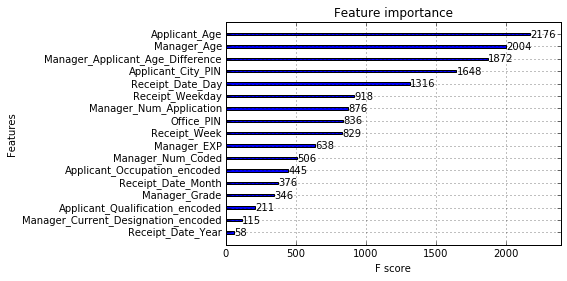

In [464]:
xgb.plot_importance(model)